This is a python script that scrapes data from China's National Bureau of Statistics. Manually downloading datasets from the website is often slow and tedious. The motivation behind this project is to allow users to easily and quickly retrieve the data points so data analysis can be performed on it. 


In [36]:
from requests import session
from multiprocessing.dummy import Pool as ThreadPool 
import pandas as pd
import functools
import numpy as np


Here is a list of codes and their corresponding datasets.

In [ ]:
price_indices = {
	'A01010101': 'Consumer Price Index (The same month last year=100)', 
	'A01080101': 'Producer Price Index for Industrial Products (The same _month last year=100)', 
	'A01010201': 'Consumer Price Index (The same month last year=100) old', 
	'A01040101': 'Retail Price Index (The same month last year=100)'}

fixed_assets_investments = {
	'A130C01': 'Investment in Private Fixed Assets, Accumulated(100 million yuan)',
	'A130101': 'Investment Actually Completed in Fixed Assets, Accumulated (100 million yuan)', 
	'A13070B01': 'Investment in Fixed Assets, Real Estate, Accumulated',
	"A13060B01": "Investment in Fixed Assets, Real Estate, Accumulated_old",
	"A13070301": "Investment in Fixed Assets, Manufacturing, Accumulated",
	"A13060301": "Investment in Fixed Assets, Manufacturing, Accumulated_old" }


residential_real_estate_floor_space_database = {
	'A140A01': 'Floor Space of Commercialized Residential Buildings Sold, Accumulated',
	'A140A05': 'Floor Space of Commercialized Residential Buildings Sold, forward delivery housing, Accumulated',
	'A140A03': 'Floor Space of Commercialized Residential Buildings Sold, complete dapartment, Accumulated',
	'A140503': 'Newly Started Floor Space of Commercialized Residential Buildings, Accumulated',
	'A140205': 'Sources of Funds of Enterprises for Real Estate Development, Accumulated',
	'A140105': 'Total Investment in Residential Buildings in Real _Estate Development, Accumulated',
	'A140101': 'Real estate investment - Cumulative Value ($100 million)' }

land_area_purchases_investment_growth_and_RE_total = {
	"A140205":"Sources of Funds of Enterprises for Real Estate _Development, Accumulated",
	'A140301': 'Development and Sales of Real Estate, Land Space _Purchased, Accumulated',
	'A130105': "Investment Actually Completed by Enterprises for Real _Estate Development, Accumulated",
	'A140401': 'Floor Space of Real Estate Under Construction, Accumulated', 
	'A140403': 'Floor Space of Real Estate Started This Year, Accumulated', 
	'A140405': 'Floor Space of Real Estate Completed, Accumulated',
	'A140303': 'Development and Sales of Real Estate, Transaction _Value of Land, Accumulated', }

financial_and_fiscal = {
	'A1A0101': 'Government Revenue, Current Period',
	'A1B0103': 'Money (M1) Supply, period-end', 
	'A1B0101': 'Money and Quasi-Money (M2) Supply, period-end', 
	'A1A0201': 'Government Expenditure , Current Period', 
	'A1B0105': 'Currency in Circulation (M0) Supply, period-end'}

export_import_FDI_Industrial_profit_whole_sales = {
	'A160105': 'Value of Exports, Current Period',
	'A150101': 'Retail Sales of Consumer Goods, Current Period', 
	'A16020B': 'Foreign Direct Investment Actually Utilized, Accumulated', 
	'A160109': 'Value of Imports, Current Period',
	'A02090N': 'Revenue from Principal Business, Accumulated', 
	'A02090H': 'Total Assets, Accumulated',
	'A020J18': 'Total Profits of Private Industrial Enterprises, _Accumulated ',
	'A020918': 'Total Profits, Accumulated ', 
	'A170205':'Freight Ton-Kilometers of Railways, Current Period',
	'A02091A': 'Total Profits, Accumulated Growth Rate', 'A020915': 'Interest Expenses, Accumulated',
	'A020101': 'Value-added of Industry, Growth Rate (The same period _last year=100)',
	'A020912': 'Financial Costs, Accumulated ', 'A02090K': 'Total Liabilities, Accumulated',
	'A02090P': 'Revenue from Principal Business, Accumulated Growth _Rate', 
}

In [9]:
def fetch_data(code,name):
	with session() as c:
		# data is a messy json-like set of data in reverse chronological order
		data = c.post(base+code+suffix).content.split('"data":'.encode("utf8"))[::-1]
		# filtering out dates that are without data
		available_data = [item for item in data if 'hasdata":true' in str(item)]
		# Pick out the data points
		data_points = [float(item.split(',"dotcount'.encode("utf8"))[0]) for item in available_data]
		# Pick out the relevant dates
		date = [int(item.split('","wdcode":"sj"}]'.encode("utf8"))[0].split('},{"valuecode":"'.encode("utf8"))[1]) for item in available_data]
		# Convert both the data and dates to DataFrame, using the dates as the index
		df = pd.DataFrame({name: data_points})
		# Formatting to date format
		dates_formatted = pd.to_datetime(pd.Series(date), format="%Y%m").dt.date
		df.index = dates_formatted
		
		return df

Below: user assigned start year and start month. Earliest year is 1998, month takes an integer from 1-12.

In [66]:
start_year = 2010
start_month = 1

In [67]:
# URL taken from netwprk monitoring the NBS website
base='http://data.stats.gov.cn/english/easyquery.htm?m=QueryData&dbcode=hgyd&rowcode=zb&colcode=sj&wds=[]&dfwds=[{"wdcode":"zb","valuecode":"'
suffix='"},{"wdcode":"sj","valuecode":"%s0%s-"}]'%(str(start_year),str(start_month))

def time_index():
    with session() as c:
        # Checking the latest data point by taking the lenght of data returned (earliest is 1998 January)
        json_data = c.post(base+'A130C01'+suffix).content.split('{"cn'.encode("utf8"))
        # Creating a monthly time index
        time_index = ['%s-01-%s'%(start_month+i%12,start_year+i//12) for i in range (len(json_data)-2)]
        df_time_index = pd.DataFrame({"Date":pd.to_datetime(pd.Series(time_index)).dt.date})
        return df_time_index
    

Below: user assigned codes and datasets to be retrieved. The script will refer to the code when retrieving the data - it will output NaN if code doesn't exist. The name of the datasets can be edited.

In [68]:
list_of_indices = {
	'A01040101': 'Retail Price Index (The same month last year=100)', 
	'A01080101': 'Producer Price Index for Industrial Products (The same month last year=100)'
}

In [72]:
# Creating a list of code and names from the dictionary to be used in pool
codes = [code for code in list_of_indices]
names = [list_of_indices[code] for code in list_of_indices]

pool = ThreadPool(4)
# Uing multihreading to run fetch_data multiple times at once
results = list(pool.starmap(fetch_data, zip(codes, names)))
# Insert time_index at position 0 to be merged with results
df_time_index = time_index()
results.insert(0, df_time_index)
# Iteratively merge all the results into one DataFrame
output = functools.reduce(lambda df1, df2: pd.merge(df1, df2, how="left", left_on="Date", right_index=True), results).set_index("Date")

output.iloc[::-1].head() #reverse chronological order

,Retail Price Index (The same month last year=100),Producer Price Index for Industrial Products (The same month last year=100)
Date,,
2017-08-01,101.143422,106.3
2017-07-01,100.665039,105.5
2017-06-01,100.896444,105.5
2017-05-01,101.102850,105.5
2017-04-01,100.907632,106.4


You can also choose to plot the data points, although there are many services online (such as trading economics) that can do it for you. The main function of this program is to retrieve the data points themselves. Below is just an example, different datasets may require different scales.

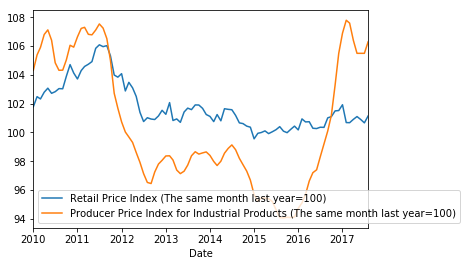

In [70]:
import matplotlib.pyplot as plt
%matplotlib inline
output.plot()